# Time series analysis as supervised learning

The remaining parts of the project will build models for time series data using Keras.

We will be using the mortgage affordability provided by Zillow https://www.zillow.com/research/data/ we have seen previously.

The project repository includes the data and utility functions to load and plot it

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import affordability_lib.newutils as newutils

afford_df = newutils.get_affordability_df()
afford_df.head(10)

,RegionID,RegionName,SizeRank,1979-03,1979-06,1979-09,1979-12,1980-03,1980-06,1980-09,...,2014-12,2015-03,2015-06,2015-09,2015-12,2016-03,2016-06,2016-09,2016-12,2017-03
324,394913,"New York, NY",1,0.261700,0.278316,0.284399,0.319438,0.379845,0.318970,0.337586,...,0.241961,0.240494,0.247387,0.245957,0.249606,0.241544,0.239503,0.240021,0.265376,0.269264
325,753899,"Los Angeles-Long Beach-Anaheim, CA",2,0.357694,0.388161,0.401762,0.459422,0.541508,0.464528,0.486750,...,0.383162,0.382531,0.396277,0.395686,0.402116,0.393042,0.390708,0.386895,0.430334,0.433476
326,394463,"Chicago, IL",3,0.261928,0.276790,0.276248,0.309709,0.353099,0.299344,0.295616,...,0.134913,0.134063,0.139074,0.137962,0.138784,0.134412,0.133701,0.132856,0.147025,0.149054
327,394514,"Dallas-Fort Worth, TX",4,0.301131,0.328453,0.340857,0.386321,0.452818,0.376912,0.394715,...,0.118163,0.117663,0.124935,0.128167,0.133517,0.131539,0.133219,0.135142,0.149861,0.152387
328,394974,"Philadelphia, PA",5,0.204333,0.215107,0.219247,0.247690,0.295396,0.248018,0.260259,...,0.141915,0.139100,0.142831,0.141625,0.142089,0.137387,0.135599,0.135064,0.148746,0.148559
329,394692,"Houston, TX",6,0.243178,0.265630,0.268049,0.294382,0.342770,0.291661,0.292763,...,0.112149,0.113520,0.118255,0.119155,0.122370,0.120863,0.120717,0.120675,0.132078,0.130511
330,395209,"Washington, DC",7,0.254252,0.264869,0.277353,0.314773,0.373035,0.319475,0.337635,...,0.174821,0.173381,0.178910,0.177032,0.178584,0.172367,0.169965,0.168010,0.185774,0.186239
331,394856,"Miami-Fort Lauderdale, FL",8,0.267852,0.284229,0.287053,0.332037,0.392403,0.334098,0.360938,...,0.181766,0.183585,0.194088,0.197580,0.203430,0.197855,0.198292,0.199508,0.221129,0.222176
332,394347,"Atlanta, GA",9,0.248301,0.264578,0.271742,0.312490,0.371988,0.307385,0.322451,...,0.113326,0.113214,0.117454,0.118066,0.120754,0.117895,0.117187,0.116937,0.130104,0.131081
333,394404,"Boston, MA",10,0.222021,0.237248,0.239940,0.276893,0.316496,0.271210,0.285134,...,0.212892,0.210786,0.216809,0.217371,0.221722,0.215844,0.214103,0.212644,0.236357,0.239656


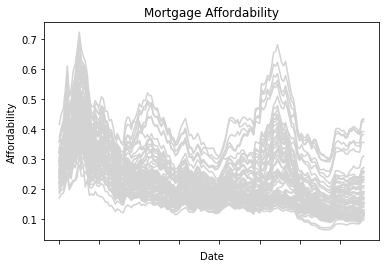

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
newutils.plot_affordability_series(afford_df)
plt.show()

## Getting data ready

We will build models that forecast mortgage one-year-out affordability based on the previous 4 years of affordability values. To obtain data for model building we provide the class `TSExampleGenerator` in the `affordability_lib.utils` module. This class does a bunch of things so let's take a look by parts.

First, let's initialize the object. Here, we will set important parameters for our model building. We'll explain the parameters below

In [4]:
from affordability_lib.newutils import TSExampleGenerator
example_generator_factory = TSExampleGenerator(afford_df, horizon=4, n_prediction_years=4,
                                      n_test_quarters = 4, n_val_quarters=4,
                                      normalize=True)

The parameters we pass have the following purpose:
- `afford_df`: the affordability data frame
- `horizon=4`: how far from the last observed timepoint do we make predictions, since we are making one-year-out predictions, we have a 4 quarter horizon
- `n_prediction_years`: how many years of data we use to make predictions, here we use 4 years, which gives us 16 total time points to use for predictions. Therefore, we have sequences of length 16, to make predictions of sequences of length 1
- `n_test_quarters`: we split the dataset into train, validation and test, here we specify that the **last four quarters** of data are to be used as targets for testing
- `n_val_quarters`: here we set that the four quarters preceeding the quarters above will be used as targets for validation, all the remaning data will be used for training
- `normalize`: standardize timeseries for each region by centering and scaling using region-specific mean and standard deviation. These parameters are computed from the training portion of the sequences only.

Once we have the object above we can get generators for the training, validation and testing portions of the dataset as follows:

In [5]:
# get generator for testing portion of dataset
test_generator, num_test_steps = example_generator_factory.get_test_gen(batchsize=20)
print(test_generator)
print(num_test_steps)

<generator object _example_generator at 0x000002166D672A40>
15


The above states that `test_generator` is a python generator. These are objects we can use in iterations using the `next` keyword. For example, to get a batch of 20 test sequences I can do the following:

In [6]:
X, y = next(test_generator)
print(X.shape)
print(y.shape)

(20, 16, 1)
(20,)


Note that the shape of `X` has three dimensions because sequence models in keras require it. The first dimension is the number of sequences, the second dimension the number of steps in the sequence (time), and the third dimension the dimensionality of the observations at each timestep (here 1 since we only observe affordability, in other situations this could be a multidimensional vector).

The way this code is designed, we can call the `next` keyword on these generators infinitely as it is easier to use within keras that way. The `num_test_steps` returned above is used to ensure that we generate enough examples to cycle through at least once through the corresponding portion of the dataset. For instance, the following loop generates all test examples in the dataset.

In [7]:
for i in range(num_test_steps):
    X, y = next(test_generator)

## Baseline model

To get a sense of the problem, let's use a baseline model that uses average mortgage affordability over the previous four years to predict one-year-out affordability. Let's try this model on the validation dataset and compute it's median absolute error.

In [8]:
import numpy as np

def evaluate_naive():
    batch_maes = []
    gen, num_steps = example_generator_factory.get_val_gen(batchsize=20)
    for step in range(num_steps):
        X, y = next(gen)
        yhat = np.mean(X, axis=1)
        mae = np.median(np.abs(y - yhat))
        batch_maes.append(mae)
    return batch_maes

naive_maes = evaluate_naive()
print(np.mean(naive_maes))
print(np.std(naive_maes))

0.27454311314151586
0.05348667369435827


## Model building

Let's build a few models for this task using keras. For all of these use `RMSprop` as the gradient descent algorithm, and `median absolute error` as the loss function. For each of the model plot training and validation error across epochs and comment on their behavior. Is the model learning anything, is it overfitting, how stable is it, etc. For each model, report median absolute error on the validation set.

### Model 1: Linear Regression 

Train a linear regression model using Keras for this task.

- Recall that for linear regression we want to build a model

$$
f = Xw + b
$$ 

where in this case, $X$ will be a matrix with 16 columns, corresponding to the values of affordability for the previous four years.

The first layer in your network will be a `Flatten` layer since this is not a sequence model. This is true of the next two models as well. 

The general structure of your models will be as follows:

In [9]:
# Model 1: Linear Regression
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import numpy

def model_LR():

    model = Sequential()
    model.add(layers.Flatten(input_shape=(16,1)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='rmsprop', loss='mae')
    return model

Using TensorFlow backend.


Epoch 1/20
540/540 [==============================] - 1s 2ms/step - loss: 0.1887 - val_loss: 0.1449
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 0.1001 - val_loss: 0.1931
Epoch 3/20
540/540 [==============================] - 1s 3ms/step - loss: 0.0931 - val_loss: 0.2240
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0877 - val_loss: 0.2409
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0833 - val_loss: 0.2335
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0797 - val_loss: 0.2071
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0760 - val_loss: 0.2241
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0733 - val_loss: 0.2125
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0702 - val_loss: 0.1977
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0678 - val_loss: 0.1912

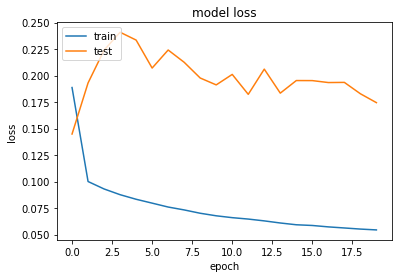

In [10]:
# Model 1: using history to make plots of training and validation loss

model = model_LR()
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=num_val_steps)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
# Model 1: making predictions on the test set and displaying a few predicted results
y_pred = model.predict(X)
for i in range(0,10):
    print("X=%s, Predicted=%s" % (X[i], y_pred[i]))

X=[[-1.1798719 ]
 [-1.25434213]
 [-1.30341649]
 [-1.35632617]
 [-1.28939572]
 [-1.17143299]
 [-1.04964888]
 [-1.02482942]
 [-1.04086297]
 [-1.07285205]
 [-1.07681502]
 [-1.13425851]
 [-1.14356607]
 [-1.07766172]
 [-1.06617028]
 [-1.0242877 ]], Predicted=[-0.6839199]
X=[[-1.11251515]
 [-1.20158022]
 [-1.23400987]
 [-1.2982412 ]
 [-1.24756042]
 [-1.09840164]
 [-0.9497255 ]
 [-0.94825303]
 [-0.97745792]
 [-1.03697513]
 [-1.0430886 ]
 [-1.10647327]
 [-1.09724187]
 [-0.99424668]
 [-0.97298256]
 [-0.9299755 ]], Predicted=[-0.6026151]
X=[[-1.29376039]
 [-1.40558612]
 [-1.47978278]
 [-1.55988816]
 [-1.4894706 ]
 [-1.31604454]
 [-1.14096948]
 [-1.11937745]
 [-1.14881034]
 [-1.19497954]
 [-1.13510513]
 [-1.20573958]
 [-1.19445548]
 [-1.05359967]
 [-1.01670749]
 [-0.95943962]], Predicted=[-0.48300323]
X=[[-1.60187355]
 [-1.6185729 ]
 [-1.61184182]
 [-1.63458294]
 [-1.56348126]
 [-1.39154456]
 [-1.14240318]
 [-1.05570606]
 [-0.97352347]
 [-0.92266796]
 [-0.91694362]
 [-0.94135198]
 [-0.93360011]
 

In [12]:
# Model 1: Evaluation
mae = np.mean(history.history['val_loss'])
print("Results: MAE = %.4f" % (mae))

Results: MAE = 0.1989


# Analysis of Model 1: Linear Regression

We note that the error loss is decreasing with each epoch, which indicates the model is learning well. However on the validation set, the model performs haphazardly which seems to tell us it's not very stable.

### Model 2: Single Layer Feed-Forward Neural Network

Train a single layer feed forward neural network using Keras.

Don't worry about tuning parameters yet (i.e., the number of units in the hidden layer units). Choose a number and go with it.

In [13]:
# Model 2: Single Layer Feed-forward Neural Network
def model_SLFFNN():

    model = Sequential()
    model.add(layers.Flatten(input_shape=(16,1)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='rmsprop', loss='mae')
    return model

Epoch 1/20
540/540 [==============================] - 1s 2ms/step - loss: 0.1758 - val_loss: 0.0969
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 0.1020 - val_loss: 0.1330
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0889 - val_loss: 0.1236
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0797 - val_loss: 0.1310
Epoch 5/20
540/540 [==============================] - 1s 3ms/step - loss: 0.0736 - val_loss: 0.1246
Epoch 6/20
540/540 [==============================] - 1s 3ms/step - loss: 0.0696 - val_loss: 0.1329
Epoch 7/20
540/540 [==============================] - 2s 3ms/step - loss: 0.0663 - val_loss: 0.1182
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0634 - val_loss: 0.1299
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0609 - val_loss: 0.1341
Epoch 10/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0583 - val_loss: 0.1518

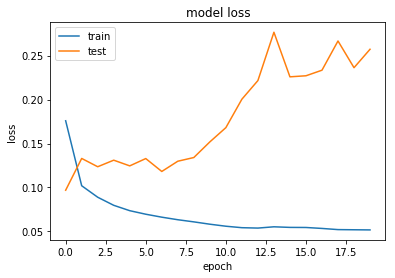

In [14]:
# Model 2: using history to make plots of training and validation loss

model = model_SLFFNN()
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=num_val_steps)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# Model 2: Evaluation
mae = np.mean(history.history['val_loss'])
print("Results: MAE = %.4f" % (mae))

Results: MAE = 0.1794


### Model 3: Deep Neural Network

Train a neural network with one or more layers for this task. 

Here, try tuning parameters (the number of hidden layers, and the number of units per layer). Use MAE on validation set as a guide.

In [17]:
# Model 3a: starting with a simple model, number of hidden layers = 1, neurons in the hidden layer = 16
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def simple_model():

    model = Sequential()
    model.add(layers.Flatten(input_shape=(16,1)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='rmsprop', loss='mae')
    
    return model

# Model 3a: Evaluation

model = simple_model()
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

for i in range(num_val_steps):
    X_val, y_val = next(val_gen)
    
mae = np.mean(history.history['val_loss'])
print("\n")
print("Results: MAE = %.4f" % (mae))
    
#seed = 7 # fix random seed for reproducibility
#numpy.random.seed(seed)
#estimator = KerasRegressor(build_fn=baseline_model, epochs=20, batch_size=5, verbose=0)
#kfold = KFold(n_splits=10, random_state=seed)
#results = cross_val_score(estimator, X, y, cv=kfold)
#print("Results: MAE = %.2f" % (results.mean()))

Epoch 1/20
540/540 [==============================] - 2s 3ms/step - loss: 0.2837 - val_loss: 0.1095
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0678 - val_loss: 0.2150
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0652 - val_loss: 0.2180
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0641 - val_loss: 0.2276
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0632 - val_loss: 0.2122
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0626 - val_loss: 0.2016
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0621 - val_loss: 0.1985
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0612 - val_loss: 0.2227
Epoch 9/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0605 - val_loss: 0.2128
Epoch 10/20
540/540 [==============================] - 1s 3ms/step - loss: 0.0599 - val_loss: 0.2208

In [18]:
# Model 3b: deeper model, number of hidden layers = 2, neurons in the 1st hidden layer = 64, neurons in the 2nd hidden layer = 128

def deeper_network_model():

    model = Sequential()
    model.add(layers.Flatten(input_shape=(16,1)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='rmsprop', loss='mae')
    
    return model

# Model 3b: Evaluation

model = deeper_network_model()
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=num_val_steps)
    
mae = np.mean(history.history['val_loss'])
print("\n")
print("Results: MAE = %.2f" % (mae))
#estimator = KerasRegressor(build_fn=deeper_network_model, epochs=20, batch_size=5, verbose=0)
#kfold = KFold(n_splits=10, random_state=seed)
#results = cross_val_score(estimator, X_val, y_val, cv=kfold)
#print("Results: MAE = %.2f" % (results.mean()))

Epoch 1/20
540/540 [==============================] - 1s 3ms/step - loss: 0.1654 - val_loss: 0.1008
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0850 - val_loss: 0.1569
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0704 - val_loss: 0.1679
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0655 - val_loss: 0.1255
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0623 - val_loss: 0.1348
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0595 - val_loss: 0.1273
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0563 - val_loss: 0.1445
Epoch 8/20
540/540 [==============================] - 1s 3ms/step - loss: 0.0540 - val_loss: 0.1548
Epoch 9/20
540/540 [==============================] - 2s 3ms/step - loss: 0.0509 - val_loss: 0.1589
Epoch 10/20
540/540 [==============================] - 1s 3ms/step - loss: 0.0489 - val_loss: 0.1744

In [19]:
# Model 3c: wider model, number of hidden layers = 1, neurons in the hidden layer = 1024

def wider_network_model():

    model = Sequential()
    model.add(layers.Flatten(input_shape=(16,1)))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='rmsprop', loss='mae')
    
    return model

# Model 3c: Evaluation

model = wider_network_model()
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=num_val_steps)
    
mae = np.mean(history.history['val_loss'])
print("\n")
print("Results: MAE = %.4f" % (mae))

#estimator = KerasRegressor(build_fn=wider_network_model, epochs=20, batch_size=5, verbose=0)
#kfold = KFold(n_splits=10, random_state=seed)
#results = cross_val_score(estimator, X_val, y_val, cv=kfold)
#print("Results: MAE = %.2f" % (results.mean()))

Epoch 1/20
540/540 [==============================] - 1s 3ms/step - loss: 0.1974 - val_loss: 0.1161
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 0.1168 - val_loss: 0.1554
Epoch 3/20
540/540 [==============================] - 2s 4ms/step - loss: 0.0845 - val_loss: 0.1677
Epoch 4/20
540/540 [==============================] - 1s 3ms/step - loss: 0.0765 - val_loss: 0.1710
Epoch 5/20
540/540 [==============================] - 1s 3ms/step - loss: 0.0721 - val_loss: 0.1770
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0695 - val_loss: 0.1735
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0674 - val_loss: 0.1778
Epoch 8/20
540/540 [==============================] - 1s 2ms/step - loss: 0.0656 - val_loss: 0.1676
Epoch 9/20
540/540 [==============================] - 1s 3ms/step - loss: 0.0639 - val_loss: 0.1720
Epoch 10/20
540/540 [==============================] - 2s 3ms/step - loss: 0.0627 - val_loss: 0.1705

# Analysis of Deep Neural Networks

We note that the median absolute error (MAE) is the lowest for the wider network 3c (with a single hidden layer and 1024 neurons) which indicates it outperforms the rest of the two variations of networks with different parameters. The deeper model 3b also performs reasonably well and comes a close second to the wider network model. 

### Model 4: Single layer recurrent neural network

Train a recurrent neural network with a single layer, using a `GRU` recurrent cell. 

Look at documentation for the GRU layers in keras: https://keras.io/layers/recurrent/

You will not need a `Flatten` layer in these networks.

Epoch 1/20
540/540 [==============================] - 5s 10ms/step - loss: 0.2187 - val_loss: 0.1317
Epoch 2/20
540/540 [==============================] - 4s 8ms/step - loss: 0.0886 - val_loss: 0.1294
Epoch 3/20
540/540 [==============================] - 5s 9ms/step - loss: 0.0839 - val_loss: 0.0905
Epoch 4/20
540/540 [==============================] - 5s 9ms/step - loss: 0.0770 - val_loss: 0.0833
Epoch 5/20
540/540 [==============================] - 5s 9ms/step - loss: 0.0647 - val_loss: 0.0881
Epoch 6/20
540/540 [==============================] - 5s 9ms/step - loss: 0.0607 - val_loss: 0.0924
Epoch 7/20
540/540 [==============================] - 5s 9ms/step - loss: 0.0590 - val_loss: 0.0930
Epoch 8/20
540/540 [==============================] - 5s 9ms/step - loss: 0.0575 - val_loss: 0.0962
Epoch 9/20
540/540 [==============================] - 5s 9ms/step - loss: 0.0553 - val_loss: 0.0926
Epoch 10/20
540/540 [==============================] - 5s 9ms/step - loss: 0.0534 - val_loss: 0.092

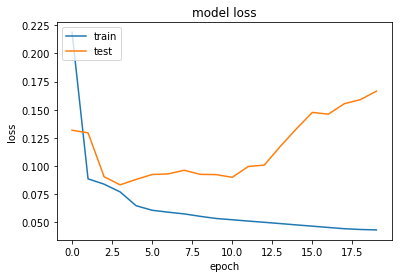



Results: MAE = 0.1152


In [20]:
# Model 4: Single layer RNN

from keras.layers.recurrent import GRU

def SL_RNN():

    model = Sequential()
    model.add(layers.GRU(16, input_shape=(16,1)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='rmsprop', loss='mae')
    
    return model

# Model 4: Evaluation

model = SL_RNN()
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
    
mae = np.mean(history.history['val_loss'])
print("\n")
print("Results: MAE = %.4f" % (mae))

# Analysis of RNN

We note that our simple recurrent model outperforms all the previous network models. From the plotting of the training and validation losses, we also see that the model is more stable, however after the 10th epoch the validation error rises while the training error continues to decrease, which indicates that the model is overfitting after the 10th epoch.

### Model 5: Single layer recurrent neural network with dropout

Train a recurrent neural network with a single layer, using a GRU recurrent cell.

Look at documentation for the GRU layers in keras: https://keras.io/layers/recurrent/

Use the `dropout` and `recurrent_dropout` arguments to implement weight dropout in the RNN. 

Epoch 1/20
540/540 [==============================] - 6s 11ms/step - loss: 0.2803 - val_loss: 0.2156
Epoch 2/20
540/540 [==============================] - 6s 11ms/step - loss: 0.1433 - val_loss: 0.1899
Epoch 3/20
540/540 [==============================] - 6s 10ms/step - loss: 0.1266 - val_loss: 0.1977
Epoch 4/20
540/540 [==============================] - 5s 10ms/step - loss: 0.1246 - val_loss: 0.1950
Epoch 5/20
540/540 [==============================] - 6s 10ms/step - loss: 0.1243 - val_loss: 0.1856
Epoch 6/20
540/540 [==============================] - 5s 10ms/step - loss: 0.1229 - val_loss: 0.1839
Epoch 7/20
540/540 [==============================] - 5s 10ms/step - loss: 0.1200 - val_loss: 0.2026
Epoch 8/20
540/540 [==============================] - 5s 10ms/step - loss: 0.1136 - val_loss: 0.1901
Epoch 9/20
540/540 [==============================] - 5s 9ms/step - loss: 0.1077 - val_loss: 0.2175
Epoch 10/20
540/540 [==============================] - 5s 10ms/step - loss: 0.1014 - val_los

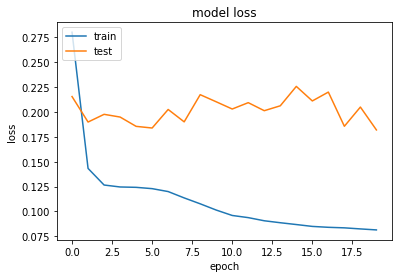



Results: MAE = 0.2019


In [21]:
# Model 5: Single layer RNN with dropout

from keras.layers.recurrent import GRU

def SL_RNN_Dropout():

    model = Sequential()
    model.add(layers.GRU(16, input_shape=(16,1), dropout = 0.25, recurrent_dropout = 0.5))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='rmsprop', loss='mae')
    
    return model

# Model 5: Evaluation

model = SL_RNN_Dropout()
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
    
mae = np.mean(history.history['val_loss'])
print("\n")
print("Results: MAE = %.4f" % (mae))

### Model 6: Deep RNN 

Train a recurrent neural network with two or more layers, with or without dropout. Here experiment with number and size of layers using validation error as a guide.

Epoch 1/20
540/540 [==============================] - 5s 9ms/step - loss: 0.2092 - val_loss: 0.1207
Epoch 2/20
540/540 [==============================] - 5s 9ms/step - loss: 0.0890 - val_loss: 0.0862
Epoch 3/20
540/540 [==============================] - 4s 8ms/step - loss: 0.0792 - val_loss: 0.1143
Epoch 4/20
540/540 [==============================] - 4s 8ms/step - loss: 0.0690 - val_loss: 0.1373
Epoch 5/20
540/540 [==============================] - 5s 9ms/step - loss: 0.0647 - val_loss: 0.1403
Epoch 6/20
540/540 [==============================] - 5s 9ms/step - loss: 0.0628 - val_loss: 0.1379
Epoch 7/20
540/540 [==============================] - 5s 9ms/step - loss: 0.0607 - val_loss: 0.1428
Epoch 8/20
540/540 [==============================] - 4s 8ms/step - loss: 0.0585 - val_loss: 0.1395
Epoch 9/20
540/540 [==============================] - 5s 8ms/step - loss: 0.0562 - val_loss: 0.1358
Epoch 10/20
540/540 [==============================] - 4s 8ms/step - loss: 0.0546 - val_loss: 0.1419

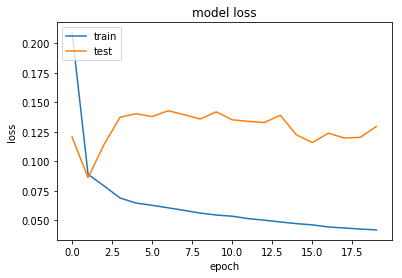



Results: MAE = 0.1285


In [22]:
# Model 6a: Deep RNN with 2 GRU layers, without dropout

from keras.layers.recurrent import GRU

def Deep_RNN():

    model = Sequential()
    model.add(layers.GRU(16, input_shape=(16,1)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='rmsprop', loss='mae')
    
    return model

# Model 6a: Evaluation

model = Deep_RNN()
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
    
mae = np.mean(history.history['val_loss'])
print("\n")
print("Results: MAE = %.4f" % (mae))

Epoch 1/20
540/540 [==============================] - 7s 13ms/step - loss: 0.2260 - val_loss: 0.2621
Epoch 2/20
540/540 [==============================] - 6s 11ms/step - loss: 0.1513 - val_loss: 0.2513
Epoch 3/20
540/540 [==============================] - 6s 11ms/step - loss: 0.1425 - val_loss: 0.2415
Epoch 4/20
540/540 [==============================] - 6s 11ms/step - loss: 0.1336 - val_loss: 0.3067
Epoch 5/20
540/540 [==============================] - 6s 11ms/step - loss: 0.1265 - val_loss: 0.3322
Epoch 6/20
540/540 [==============================] - 6s 11ms/step - loss: 0.1201 - val_loss: 0.3071
Epoch 7/20
540/540 [==============================] - 6s 12ms/step - loss: 0.1143 - val_loss: 0.3078
Epoch 8/20
540/540 [==============================] - 6s 11ms/step - loss: 0.1052 - val_loss: 0.3047
Epoch 9/20
540/540 [==============================] - 6s 11ms/step - loss: 0.1034 - val_loss: 0.2929
Epoch 10/20
540/540 [==============================] - 6s 12ms/step - loss: 0.0957 - val_lo

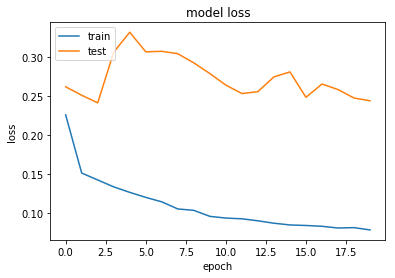



Results: MAE = 0.2740


In [23]:
# Model 6b: Deep RNN with 4 layers, and with dropout

from keras.layers.recurrent import GRU

def Deep_RNN_with_dropout():

    model = Sequential()
    model.add(layers.GRU(64, input_shape=(16,1), dropout = 0.3, recurrent_dropout = 0.6))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='rmsprop', loss='mae')
    
    return model

# Model 6b: Evaluation

model = Deep_RNN_with_dropout()
train_gen, num_train_steps = example_generator_factory.get_train_gen(batchsize=20)
val_gen, num_val_steps = example_generator_factory.get_val_gen(batchsize=20)

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
    
mae = np.mean(history.history['val_loss'])
print("\n")
print("Results: MAE = %.4f" % (mae))

# Conclusion

- Firstly, we note that almost all our models perform better than the baseline model (MAE = 0.27), with the Deep and simple RNN models (without dropout) performing the best with a MAE = 0.12 (approx).
- Generally, the recurrent neural networks outperform the flat networks by almost 25% improvement over the validation loss.
- However, the RNNs with dropout DO NOT perform well at all (when compared with the flat networks). This could be owing to the reason that we have very less number of data points, and when we drop 25-40% of units (for linear transformation of either inputs or the recurrent state), there is a considerable reduction in predictive power.